In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [3]:
def T(p):
    return p.T.dot(p)/2

def U(q):
    q1 = q[0]
    q2 = q[1]
    return .5*(q1**2 + q2**2) + q2*q1**2 - (1/3.)*q2**3

def dU(q):
    q1 = q[0]
    q2 = q[1]
    x1 = q1 + 2*q1*q2
    x2 = q1**2 + q2 - q2**2
    return np.array([[x1],[x2]]).reshape(2,1)

def H(p,q):
    return T(p) + U(q)

#t = np.array([[2],[3]])
#T(t)
#U(t)
#dU(t)
#H(t,t)

In [4]:
1/6

0.16666666666666666

In [5]:
p = np.array([[-.28],[.23]]).reshape(2,1)
q = np.array([[.23],[-.28]]).reshape(2,1)
H(p,q)

array([[0.12380533]])

In [6]:
def sv(du, p, q, h, time):
    steps = int(time//h)
    position = np.zeros((2,steps))
    for i in tqdm.tqdm(range(steps)):
        p -= (h/2.)*du(q)
        q += h*p
        p -= (h/2.)*du(q)
        position[:,i] = np.squeeze(q)
    return position

In [21]:
h = 1e-1
p = np.array([[-.1],[.12]]).reshape(2,1)
q = np.array([[.06],[-.09]]).reshape(2,1)
print(f'Energy: {H(p,q)}')
Q1 = sv(dU, p,q,h, 30)
p = np.array([[-.28],[.23]]).reshape(2,1)
q = np.array([[.23],[-.28]]).reshape(2,1)
print(f'Energy: {H(p,q)}')
Q2 = sv(dU, p,q,h, 30)
p = np.array([[-.3],[.31]]).reshape(2,1)
q = np.array([[-.6],[-.5]]).reshape(2,1)
print(f'Energy: {H(p,q)}')
Q3 = sv(dU, p,q,h, 30)

Energy: [[0.017969]]


100%|██████████████████████████████████████| 299/299 [00:00<00:00, 24941.27it/s]


Energy: [[0.12380533]]


100%|██████████████████████████████████████| 299/299 [00:00<00:00, 25373.22it/s]


Energy: [[0.25971667]]


100%|██████████████████████████████████████| 299/299 [00:00<00:00, 24344.78it/s]


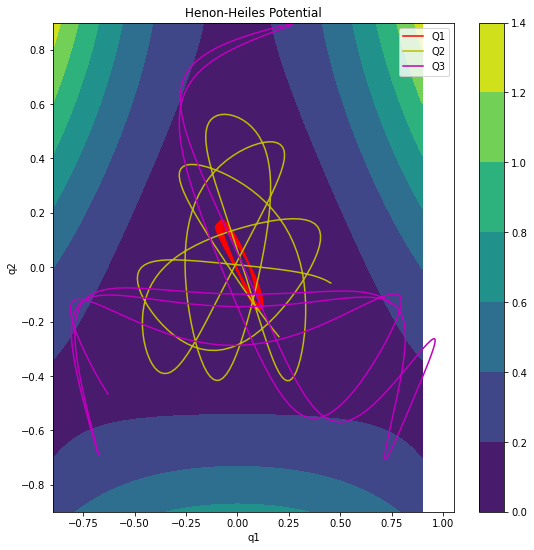

In [22]:
bnd = .9
xlist = np.linspace(-bnd, bnd, 1000)
ylist = np.linspace(-bnd, bnd, 1000)
X, Y = np.meshgrid(xlist, ylist)
Z = .5*(X**2 + Y**2) + Y*X**2 - (1/3.)*Y**3
fig,ax=plt.subplots(1,1, figsize=(9,9))
cp = ax.contourf(X, Y, Z)
ax.plot(Q1[0,:],Q1[1,:],'r', label='Q1')
ax.plot(Q2[0,:],Q2[1,:],'y', label='Q2')
ax.plot(Q3[0,:],Q3[1,:],'m', label='Q3')
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Henon-Heiles Potential')
ax.set_xlabel('q1')
ax.set_ylabel('q2')
plt.legend()
plt.show()